In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

In [14]:
train_data = pd.read_csv('/Users/yukihuang/Documents/Grinnell College/Spring2024/STA395/final project/Spaceship_Titanic/spaceship-titanic/train.csv')
test_data = pd.read_csv('/Users/yukihuang/Documents/Grinnell College/Spring2024/STA395/final project/Spaceship_Titanic/spaceship-titanic/test.csv')

In [15]:
train_data

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [16]:
# Checking for NA
na_percent = train_data.isna().mean() * 100
print(na_percent)

PassengerId     0.000000
HomePlanet      2.312205
CryoSleep       2.496261
Cabin           2.289198
Destination     2.093639
Age             2.059128
VIP             2.335212
RoomService     2.082135
FoodCourt       2.105142
ShoppingMall    2.392730
Spa             2.105142
VRDeck          2.162660
Name            2.300702
Transported     0.000000
dtype: float64


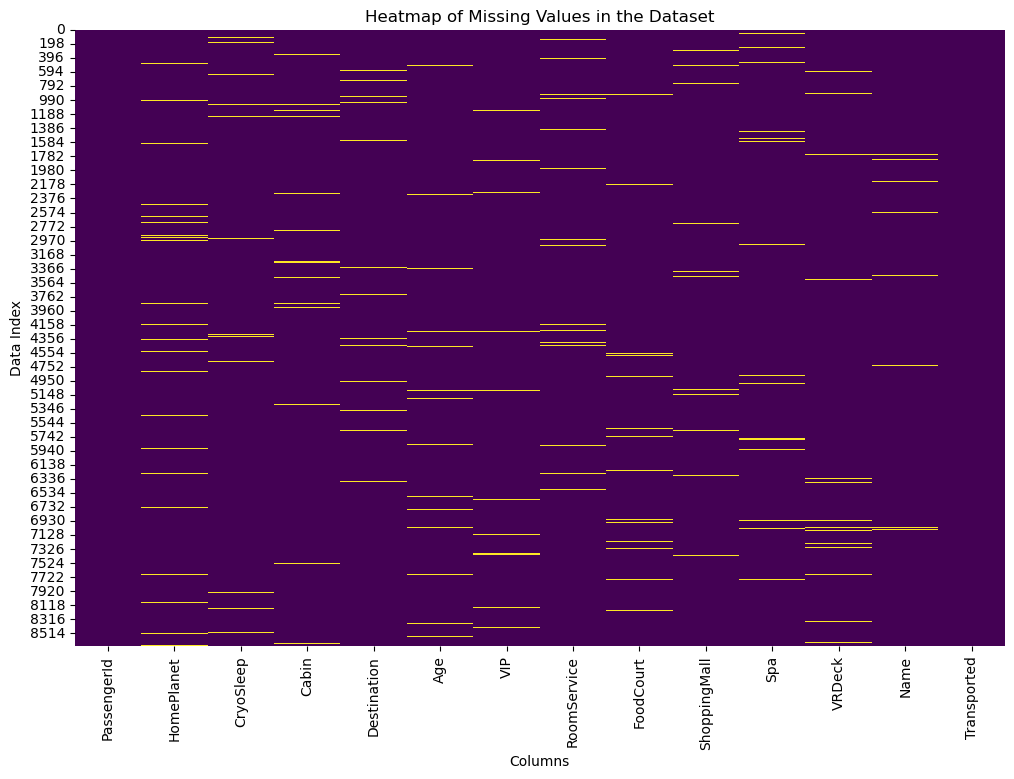

In [17]:
plt.figure(figsize=(12, 8))
sns.heatmap(train_data.isna(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Values in the Dataset')
plt.xlabel('Columns')
plt.ylabel('Data Index')
plt.show()

In [18]:
# clip outliers with threshold values to deal with the outliers
def clipping_quantile(dataframe, quantile_values = None, quantile = 0.99):
    df = dataframe.copy()
    if quantile_values is None:
        quantile_values = df[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].quantile(quantile)
    for num_column in ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]:
        num_values = df[num_column].values
        threshold = quantile_values[num_column]
        num_values = np.where(num_values > threshold, threshold, num_values)
        df[num_column] = num_values
    return df      
    
train_data = clipping_quantile(train_data, None, 0.99)
test_data = clipping_quantile(train_data, None, 0.99)

In [19]:
# Split the Cabin Column
train_data[['Deck', 'Num', 'Side']] = train_data['Cabin'].str.split('/', expand=True)
test_data[['Deck', 'Num', 'Side']] = test_data['Cabin'].str.split('/', expand=True)

# Convert 'Deck' and 'Side' into categorical variables
train_data['Deck'] = train_data['Deck'].astype('category')
train_data['Side'] = train_data['Side'].astype('category')
train_data = pd.get_dummies(train_data, columns=['Deck', 'Side', 'Destination', 'HomePlanet'])

test_data['Deck'] = test_data['Deck'].astype('category')
test_data['Side'] = test_data['Side'].astype('category')
test_data = pd.get_dummies(test_data, columns=['Deck', 'Side', 'Destination', 'HomePlanet'])

# Convert 'Num' to a numerical variable
train_data['Num'] = pd.to_numeric(train_data['Num'], errors='coerce')
test_data['Num'] = pd.to_numeric(test_data['Num'], errors='coerce')

test_passenger_id = test_data['PassengerId'].copy()

train_data_copy = train_data.copy(deep=True)
test_data_copy = test_data.copy(deep=True)

In [20]:
# Use Mode for categorical variables
numerical_features = train_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = train_data.select_dtypes(include=['object']).columns.tolist()

for feature in numerical_features:
    train_data[feature].fillna(train_data[feature].mean(), inplace=True)
    test_data[feature].fillna(train_data[feature].mean(), inplace=True)

for feature in categorical_features:
    train_data[feature].fillna(train_data[feature].mode()[0], inplace=True)
    test_data[feature].fillna(train_data[feature].mode()[0], inplace=True)

train_data = train_data.apply(pd.to_numeric, errors='coerce')
test_data = test_data.apply(pd.to_numeric, errors='coerce')

test_data['PassengerId'] = test_passenger_id

train_data.to_csv('/Users/yukihuang/Documents/Grinnell College/Spring2024/STA395/final project/Spaceship_Titanic/spaceship-titanic/train_data_mode.csv', index=False)
test_data.to_csv('/Users/yukihuang/Documents/Grinnell College/Spring2024/STA395/final project/Spaceship_Titanic/spaceship-titanic/test_data_mode.csv', index=False)

In [ ]:
target_column = 'Transported'  # adjust the column name as necessary

# Isolate target variable if it's part of the dataframe
if target_column in train_data_copy.columns:
    train_targets = train_data_copy[target_column]
    train_data_features = train_data_copy.drop(columns=[target_column])
else:
    train_data_features = train_data_copy

# Test data should not have the target column, ensure it does not
test_data_features = test_data_copy

# Identify categorical and numerical features
numerical_features = train_data_features.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = train_data_features.select_dtypes(include=['object', 'category']).columns.tolist()

# Fill missing values for numerical features
mean_imputer = SimpleImputer(strategy='mean')
train_data_features[numerical_features] = mean_imputer.fit_transform(train_data_features[numerical_features])
test_data_features[numerical_features] = mean_imputer.transform(test_data_features[numerical_features])

# Encode categorical features with handling unknown categories
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
train_data_features[categorical_features] = encoder.fit_transform(train_data_features[categorical_features].astype(str))
test_data_features[categorical_features] = encoder.transform(test_data_features[categorical_features].astype(str))

# Apply KNN Imputer
knn_imputer = KNNImputer(n_neighbors=5, weights="uniform")
train_data_features = pd.DataFrame(knn_imputer.fit_transform(train_data_features), columns=train_data_features.columns)
test_data_features = pd.DataFrame(knn_imputer.transform(test_data_features), columns=test_data_features.columns)

# If the target was in the original data, add it back to the training dataframe
if target_column in train_data_copy.columns:
    train_data_features[target_column] = train_targets

test_data['PassengerId'] = test_passenger_id

# Save processed data
train_data_features.to_csv('/Users/yukihuang/Documents/Grinnell College/Spring2024/STA395/final project/Spaceship_Titanic/spaceship-titanic/train_data_knn.csv', index=False)
test_data_features.to_csv('/Users/yukihuang/Documents/Grinnell College/Spring2024/STA395/final project/Spaceship_Titanic/spaceship-titanic/test_data_knn.csv', index=False)